# Homework 5

### CS328 — Numerical Methods for Visual Computing and Machine Learning
- - -

**Out** on Tuesday 24/11/2020, **due** on Tuesday 15/12/2020

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text. Please complete/extend this notebook for your homework submission:

* In addition to your code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.
* Before handing in, please make sure that your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use <a href="https://www.anaconda.com/products/individual">Anaconda</a>, specifically the version based on Python 3.8.
<br><div class="alert alert-warning">
Please keep in mind that homework assignments must be done individually.
</div>

## Problem -1: Warmup (not graded)

The following paper & pencil questions are meant to check your comprehension of the lecture and prior math knowledge with regards to neural networks. Please review the lecture and reading material if you find that you're unable to answer these questions.

1. What is the difference between a deep and a shallow neural network?<br><br>

2. List the building blocks of a fully connected neural network (also called multilayer perceptron).<br><br>

3. What is the role of the activation function in a neural network?<br><br>

4. A neural network has a number of paramters: the number of layers and nodes per layer, the choice of activation function, weight matrices, bias terms, etc. Which of these are optimized during training of the network?<br><br>

5. What is the difference between regression and classification?<br><br>

6. Compute the derivative of the generic function $f(x,w) = (h(w x + b) - l)^2$ with respect to $w,b$ and $x$ using the chain rule. This function models a very simple neural network with a single neuron. It depends on the scalar variables $w,b,x$ and scalar constant $l$. Think about how you would compute gradients with respect to $w,b,x$ if all variables are no longer scalars but vectors.

## 0 Prelude

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline 
%config InlineBackend.figure_format='retina'

import numpy as np
import scipy
import scipy.special
import collections

plt.rcParams['figure.figsize'] = (21.0, 6.0)

Machine learning, deep neural networks and AI have an increasing impact not only on science but also our daily life. Prime examples are natural language translation in our mobile phones, emerging autonomous driving, and medicine.
In this exercise, we apply neural networks to the domain of fashion to identify clothing articles purely from product photographs. One example use case would be to filter out falsely listed shirts when searching for a dress in an online store.

In this homework, you will get to build a complete deep learning toolchain: Specifically, you will

1. Prepare a dataset of example images and corresponding labels<br><br>

2. Construct a neural network consisting of affine and non-linear layers<br><br>

3. Implement the backpropagation algorithm<br><br>

4. Train the NN and choose a suitable network architecture

$\newcommand{\X}{\mathbf{x}}$
$\newcommand{\XA}{\mathbf{x1}}$
$\newcommand{\XB}{\mathbf{x2}}$
$\newcommand{\iA}{\mathbf{i1}}$
$\newcommand{\iB}{\mathbf{i2}}$
$\newcommand{\J}{\mathbf{J}}$
$\newcommand{\Y}{\mathbf{y}}$
$\newcommand{\W}{\mathbf{W}}$
$\newcommand{\w}{\mathbf{w}}$
$\newcommand{\A}{\mathbf{a}}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\affine}{\texttt{affine}}$
$\newcommand{\identity}{\texttt{identity}}$
$\newcommand{\relu}{\texttt{relu}}$
$\newcommand{\sigmoid}{\texttt{sigmoid}}$

$%The Matrix Cookbook is a good source to refresh vector and matrix calculus and to lookup rules for gradient computation, Chapter 2, Derivatives [2].
%[2] K. B. Petersen and M. S. Pedersen https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf$

## 1 Dataset preparation (5 Points)

Download a copy of this dataset by clicking <a href="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/data.zip">here</a> and unzip the contents so that they are located in a subdirecory ``data`` relative to the Jupyter notebook file. ([source](https://github.com/zalandoresearch/fashion-mnist)).

In the following, we load a training and test set, each with thousands of examples. The fundamental goal of AI, and of this exercise, is to develop algorithms that learn a pattern from past experiences (the training set) that is general enough to be applicable to new situations (the test set).

Both sets contain a list of images (e.g. `fashion_train['images']`) and a list of associated labels (e.g. `fashion_train['labels']`) where the 9 labels `[0, ..., 9]` correspond to the following semantic classes:

| Label | Class |
|------ |------ |
| 0 | T-shirt / top |
| 1 | Trouser       |
| 2 | Pullover      |
| 3 | Dress         |
| 4 | Coat          |
| 5 | Sandal        |
| 6 | Shirt         |
| 7 | Sneaker       |
| 8 | Bag           |
| 9 | Ankle boot    |


Execute the provided code to inspect a small subset of examples.

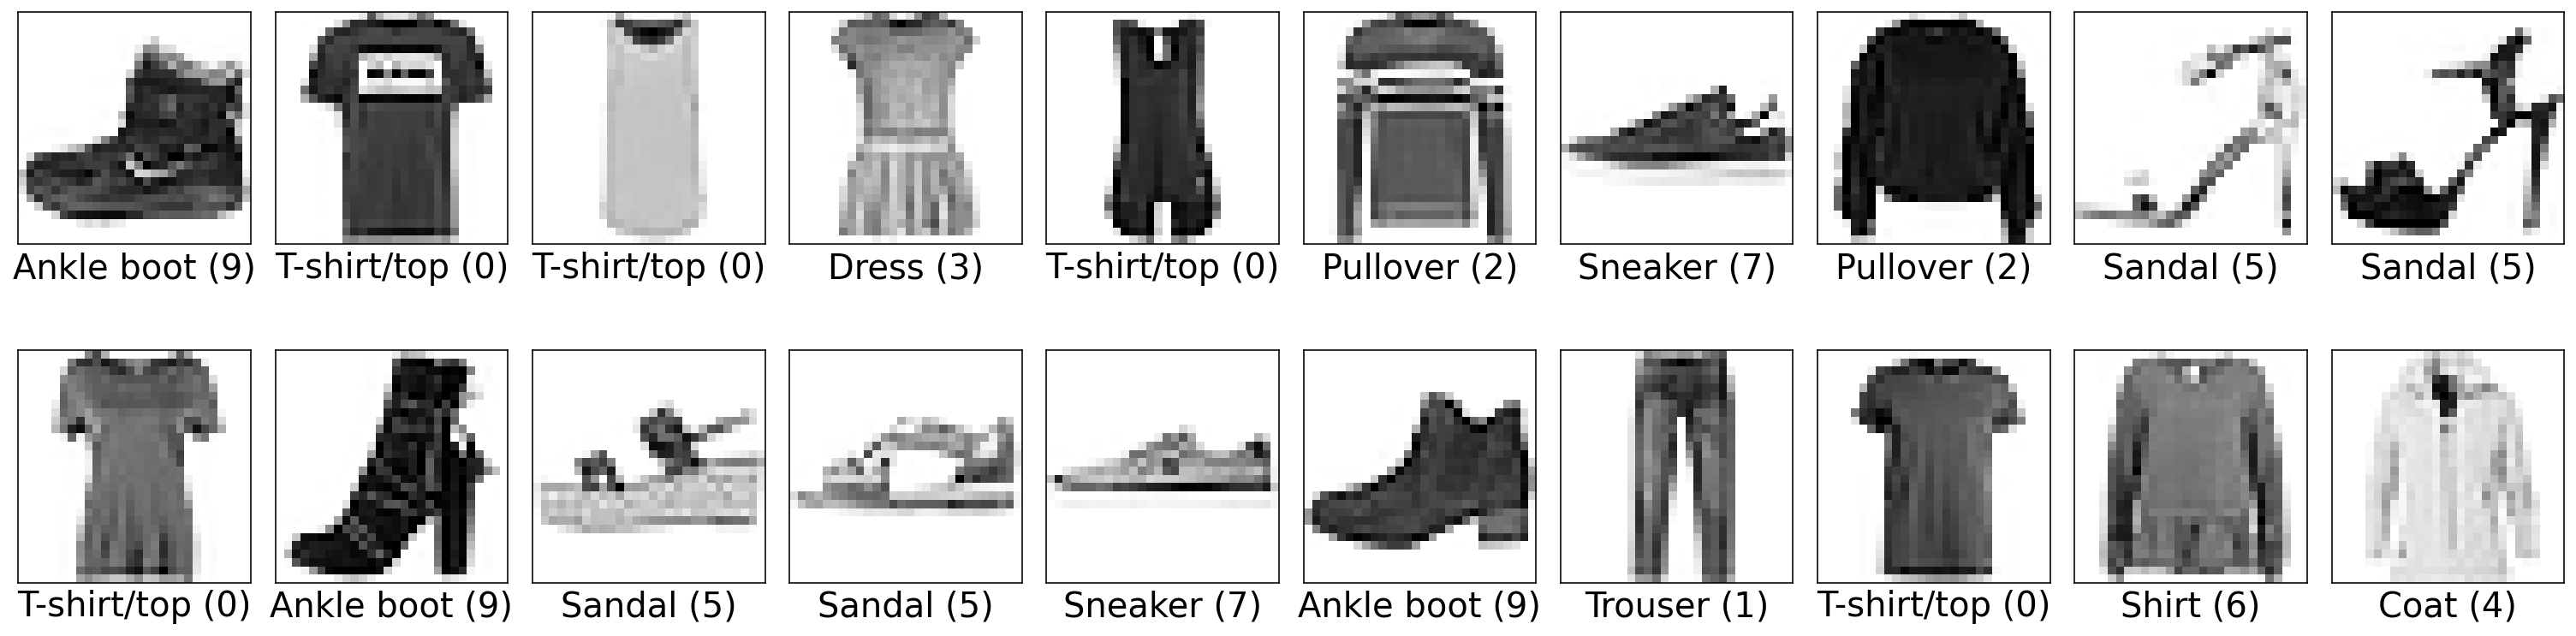

In [2]:
fashion_train = np.load('data/mnist_fashion_train.npz')
fashion_test = np.load('data/mnist_fashion_test.npz')

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Plots a list of images and corresponding labels
def plot_items(images, labels=None, gt_labels=None):
    num_images = len(images)
    images_per_row = 10
    num_rows = int(np.ceil(num_images / images_per_row))
    for i, image in enumerate(images):
        # create subfigure for image
        ax = plt.subplot(num_rows, images_per_row, i + 1)
        ax.set_xticks([]); ax.set_yticks([])
        plt.imshow(image, cmap='Greys', interpolation='None')
        
        # show label name
        if labels is not None:
            plt.xlabel("{} ({})".format(label_names[labels[i]], labels[i]), fontsize=20)
        
        # indicate correct or false prediction with a green or red border
        if gt_labels is not None:
            rect = patches.Rectangle((0,0), 27, 27, linewidth=3,
                                     edgecolor='g' if labels[i] == gt_labels[i] else 'r',
                                     facecolor='none')
            ax.add_patch(rect)

    plt.tight_layout() # remove some unnecessary space between images
    plt.show()

plot_items(fashion_train['images'][:20], fashion_train['labels'][:20])

Note that the images have a quite low resolution (28x28 pixels) to make the problem tractable with relatively simple neural networks. For higher-resolution images, convolutional neural networks with very deep architectures would be required, which is beyond the scope of this homework assignment. Yet, the principles we develop in this exercise generalize to such models and higher resolutions. 

In a first step, we will follow the common practice of normalizing the mean and standard deviation of all input variables to zero and one respectively. This process is called _whitening transformation_ and makes the problem less sensitive to the chosen network architecture, activation function, and initial weights.

**TODO:** Compute the mean pixel value and its standard deviation of the complete training set. Note that these are scalar values, computed across all pixels of all images.

In [3]:
# TODO
fashion_mean = np.mean(fashion_train['images'], axis=(0, 1, 2)) # TODO
fashion_std = np.std(fashion_train['images'], axis=(0, 1, 2)) # TODO
print('fashion_mean = {:.5f}, fashion_std =  {:.5f}'.format(fashion_mean, fashion_std))

fashion_mean = 72.80222, fashion_std =  89.96003


We use these values in the following to normalize the training and test images by subtracting the mean and dividing by the standard deviation. Furthermore, we limit the number of examples to 10k by default, to reduce execution time.

In [4]:
def fashion_prepare_regression(dataset, max_iterations=10000):
    return {'images': (dataset['images'][:max_iterations] - fashion_mean) / fashion_std,
            'labels':  dataset['labels'][:max_iterations]}

fashion_train_regression = fashion_prepare_regression(fashion_train)
fashion_test_regression = fashion_prepare_regression(fashion_test)

## 2 Constructing a fully connected artificial neural network (25 points)

We are ready to implement and deploy deep learning. Our goal is to construct a **fully connected network** consisting of $n$ hidden layers. As illustrated below, each layer consists of a number of neurons that apply non-linear activation functions on the output of the preceding layer.

<br><img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_noderep_simple_cut.png"><br>

We will now implement the invididual components of the NN.

### 2.1 Activation Units (5 points)

Non-linear activation functions are the core of NNs that allow them to outperform simple linear models.

**TODO:** Define a function ``relu(x)`` that takes a vector ``x`` as input and returns the element-wise RELU activation. Make use of ``np.maximum`` in its implementation.
Also define the function ``identity(x)`` that maps ``x`` to ``x``.

In [5]:
# TODO
def relu(x):
    return np.maximum(x, 0)

def identity(x):
    return np.array(x)

**Verify:** ``relu([-1,0,1]) == [0,0,1]`` and ``identity([-1,0,1]) == [-1,0,1]``

In [6]:
print('relu([-1, 0, 1]) =', relu([-1, 0, 1]))
print('identity([-1, 0, 1]) =', identity([-1, 0, 1]))
print('Test:', np.allclose(relu([-1, 0, 1]), [0, 0, 1]), np.allclose(identity([-1, 0, 1]), [-1, 0, 1]))

relu([-1, 0, 1]) = [0 0 1]
identity([-1, 0, 1]) = [-1  0  1]
Test: True True


### 2.2 Network definition (20 points)

We want to construct a fully connected neural network function `nn(x, weights, activation_functions)` that maps input $\X \in \R^{m_0}$ to prediction $\Y \in \R^{m_n}$ through $n$ layers of width $m_i$ and activation functions $h_i$, with $i \in (1,2,\dots,n)$. As sketched below for a network with a single hidden layer.

<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_noderep.png">

Representing each neuron separately is complex and computationally inefficient. It is more practical to group neurons into layers and to represent each layer as a vectorized function. The following illustration shows the simplification.

<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/neuralnetwork_layerrep.png">

The output $\A^{(i)}$ of layer $i$ is a vector of length $m_{i}$, the list of all outputs of individual neurons in that layer.
The output $\A^{(i-1)}$ of layer $i-1$ is the input to layer $i$.
Each neuron of layer $i$ takes the same input values, although it will generally apply different weights and bias terms.
The weighting for each of the $m_i$ neurons can thus be expressed as a single matrix multiplication $\W^{(i)} \A^{(i-1)}$, where $\W^{(i)}$ has shape $[m_n, m_{n-1}+1]$ and represents all weights of layer $i$.
Note that $\W^{(i)}$ has one dimension more than $m_{i-1}$ to encode the bias term.

**TODO:** Create a weight matrix ``W1`` filled with the value ``1`` for a layer with a single input and 5 outputs, and a second weight matrix ``W2`` (also filled with ``1``) for a layer with 5 inputs and a single output.

In [7]:
# TODO
W1 = np.ones((5, 2))
W2 = np.ones((1, 6))

**Validate:** Verify that the matrix shapes are correct. The output of the tested matrix multiplication should be (5, 6).

In [8]:
print('W1.shape = {}, W2.shape = {}'.format(W1.shape, W2.shape))
print('Test:', (W1[:, :-1] @ W2).shape == (5,6))

W1.shape = (5, 2), W2.shape = (1, 6)
Test: True


**TODO:** Implement the function ``affine(x, W)`` that computes the affine transformation of a vector $\X \in \R^{m_{i-1}}$ to a vector $\R^{m_i}$ based on the input weight matrix $\W$.

**Hint**: Note that the weight matrix includes the bias term.

In [9]:
# TODO
def affine(x, W):
    newX =  np.append(x, 1)   
    return newX.T @ W.T

**Verify:** ``affine(np.array([-1, 0, 0.5, 1, 1.5]), W2) == np.array([3])``

In [10]:
out = affine([-1, 0, 0.5, 1, 1.5], W2)
print('out =', out)
print('Test:', np.allclose(out, np.array([3])))

out = [3.]
Test: True


**TODO:** Implement the function `nn(x, W_list, h_list)`. Given the input `x`, it shall compute the complete forward pass of a neural network by chaining affine transformations and activation functions for each layer. The previously shown network graphic provides a good reference.

- `W_list` is a list of weight matrices [$\W^{(1)},\W^{(2)},\dots,\W^{(n)}$ ] where each element $\W^{(i)}$ is the weight matrix of layer $i$
- `h_list` is a list of activation functions [$h^{(1)},h^{(2)},\dots,h^{(n)}$]


In [11]:
# TODO
def nn(x, W_list, h_list):
    assert len(W_list) == len(h_list) # The two input lists are guaranteed to have the same length
    arrayLoop =  zip(W_list, h_list)
    for W,h in arrayLoop:
        x = h(affine(x, W))
    return x
    

**Verify:** The following code creates a network architecture with weights ``[W1, W2]`` and activation functions ``[relu, identity]``.<br>
Is ``output == [array([ 1.]), array([ 6.]), array([ 11.])]``?

In [12]:
def network_test(x):
    return nn(x, [W1, W2], [relu, identity])

out1 = network_test(np.array([-1]))
out2 = network_test(np.array([0]))
out3 = network_test(np.array([1]))
print("Output:", out1, out2, out3)
print("Test:", np.allclose(out1, np.array([1])), 
               np.allclose(out2, np.array([6])), 
               np.allclose(out3, np.array([11])))

Output: [1.] [6.] [11.]
Test: True True True


Congratulations! You've just built all the code that is needed to evaluate a neural network. However, an untrained network without sensible weights is not particularly useful yet.

## 3 Training a neural network (55 points)

### 3.1 Network initialization (5 points)

Random initialization of the network weights is crucial for robust training. We provide the function ``initialize_network(network_shape)`` that takes a list of layer widths ``network_shape =  ``$\ [m_0, m_1, \dots, m_n]$ and outputs corresponding weight matrices $[\W^{(1)},\dots,\W^{(n)}]$ with dimensions as introduced before. It inserts the extra dimension for the bias term and initializes it to zero. NumPy's random number generator is deterministically initialized using ``np.random.seed`` so that you will always get the same initialization.

**TODO:** Implement the function ``random_matrix(rows, columns)`` that takes the number of rows and columns as input and returns a matrix ``W`` of that shape. The elements of ``W``  shall be randomly chosen from the uniform distribution across the range $[-\sqrt{\frac{3}{m}}, \sqrt{\frac{3}{m}}]$, where $m$ is the number of columns.

<div class="alert alert-block alert-info">
The factor $\sqrt{\frac{3}{m}}$ is chosen to conserve the mean and standard deviation of zero and one. If you're interested in the details here, please refer to the (optional!) bonus questions at the end of the notebook.
</div>

**Hint**: The function ``np.random.uniform`` may be useful.

In [13]:
# TODO
def random_matrix(rows, columns):
    bound = np.sqrt(3 / columns)
    return np.random.uniform(-bound, bound, (rows, columns))

In [14]:
# Provided
def initialize_network(network_shape):
    np.random.seed(0)
    W_list = [random_matrix(network_shape[i], network_shape[i - 1]) 
              for i in range(1, len(network_shape))]
    Wb_list = [np.concatenate([W, np.zeros([W.shape[0], 1])], axis=1) for W in W_list]
    return Wb_list

**Verify:** Is your weight initialization correct? The following code computes the mean and standard deviation of a network with a single hidden layer. The mean should be roughly zero and std roughly one, but keep in mind that there is some randomness to this.

In [15]:
random_output = nn(x=np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(1000)), 
                   W_list=initialize_network([1000, 1000, 1000]),
                   h_list=[identity, identity])
print("mean = {:.6f}, std = {:.6f}".format(np.mean(random_output), np.std(random_output)))

mean = 0.030046, std = 1.034934


**Verify:** Is the dimension of the following output equal to 2? This is your first self-made **deep** neural network!

In [16]:
def network_simple(x):
    return nn(x, initialize_network([1, 5, 3, 2]), [relu, relu, identity])

out = network_simple(np.array([10]))
print("out =", out)
print("Test:", out.shape == (2,))

out = [ 4.30790412 -0.25846403]
Test: True


### 3.2 Layer-wise Jacobian matrices (10 points)

We will use stochastic gradient descent and the backpropagation algorithm to train the network. For this to work we need to derive the Jacobian matrices of all intermediate steps.<br>

Recall the definition of the Jacobian matrix of $f$ with respect to $\X$:
$$
{\displaystyle J^f_\X
=\frac{\partial f}{\partial \X}
={\begin{bmatrix}{\dfrac {\partial f_{1}}{\partial \X_{1}}}&\cdots &{\dfrac {\partial f_{1}}{\partial \X_{n}}}\\\vdots &\ddots &\vdots \\{\dfrac {\partial f_{m}}{\partial \X_{1}}}&\cdots &{\dfrac {\partial f_{m}}{\partial \X_{n}}}\end{bmatrix}}},
$$

where $f_i$ is the $i$-th output of function $f$, $\X_j$ is the $j$-th element of the input $\X$, and $\dfrac {\partial f_{i}}{\partial \X_{j}}$ the partial derivative of $f_i$ with respect to $\X_j$.<br>

#### 3.2.1 Jacobian of the activation functions

For a function $h$ that performs element wise operations, the Jacobian is of diagonal form:

<img width="200" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_h_x.png">

**TODO:** Define functions that compute the Jacobian matrices $\J^{\relu}_\X$ and 
$\J^{\identity}_\X$ of the vectorized relu and identity functions, respectively.

In [17]:
# TODO
def d_relu_d_x(x):
    return np.diag([0 if i <= 0 else 1 for i in x])
   
def d_identity_d_x(x):
    return np.diag(np.ones(len(x)))
    
    

**Verify:** Test your implementations on the vector ``x = [-1, 0, 2]``.

In [18]:
test_x = np.array([-1, 0, 2])

J_relu = d_relu_d_x(test_x)
J_identity = d_identity_d_x(test_x)

print("d_relu_d_x =\n{}".format(J_relu))
print("d_identity_d_x =\n{}".format(J_identity))
print("Test:", np.allclose(J_relu, np.array([[0, 0, 0], [0, 0, 0], [0, 0, 1]])),
               np.allclose(J_identity, np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])))

d_relu_d_x =
[[0 0 0]
 [0 0 0]
 [0 0 1]]
d_identity_d_x =
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Test: True True


#### 3.2.2 Jacobian of the affine transformation

Since the $\affine$ function has two arguments, it must be differentiated with respect to both $\mathbf{x}$ and $\W$.<br><br>

The shape of $\J^{\affine}_\X$ is dense. The following image illustrates the Jacobian matrix of ``affine(``$\mathbf{x},\W^{(2)}$ ``) `` with respect to $\mathbf{x}$:

<img width="300" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_w_x.png">

**TODO:** Implement $\J^{\affine}_\X$, i.e. the Jacobian of ``affine(x, W)`` with respect to ``x``. Note that ``W`` models the linear term and the bias term which is independent of ``x``.

In [19]:
# TODO
def d_affine_d_x(W):
    return W[:, :-1]

**Verify:** Is your implementation correct for the example input $\X = [-1,0,2]$, $\W = [[1,-2,-3,-4],[-5,-6,7,8]]$? The right output is `d_affine_d_x = [[1 -2 -3],[-5 -6 7]]`.

In [20]:
W = np.array([[1, -2, -3, -4],
              [-5, -6, 7, 8]])
out =  d_affine_d_x(W)

print("d_affine_d_x =\n{}".format(out))
print("Test:", np.allclose(out, np.array([[1, -2, -3],
                                          [-5, -6, 7]])))

d_affine_d_x =
[[ 1 -2 -3]
 [-5 -6  7]]
Test: True


The Jacobian of `affine` with respect to $\W$ is more tricky as $\W$ is actually a matrix. To simplify the matter, we reshape $\W$ into a vector (also called **flattening**) and construct the Jacobian matrix $\J^{\affine}_\W(\mathbf{x},\W)$ as before: we compute the derivative of the outputs of $\affine$ with respect to all elements of $\W$.  

The matrix has a diagonal structe as the $i$-th output is defined by row $i$ of ``W`` and is independent of rows $j \neq i$. Since each row of $\W$ is multiplied by $\X$ (ordinary matrix multiplication of $\W \X$), $\X$ is replicated in the diagonal, e.g. for $\W^{(1)}$:
<img width="400" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_w_w.png">

**TODO:** Implement $\J^{\affine}_\W$, i.e. the Jacobian of `affine(x, W)` with respect to `W`.

**Hints**:
- Recall that the weight matrix includes the bias term.
-  The diagonal structure can be constructed efficiently using a [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product), i.e. [`np.kron`](https://numpy.org/doc/stable/reference/generated/numpy.kron.html).

In [21]:
# TODO
def d_affine_d_W(x, W):
    return np.kron(np.eye(W.shape[0]), np.append(x,[1]))

**Verify:** Is your implementation correct for the example input $\X = [-1,0,2]$, $\W = [[1,-2,-3,-4],[-5,-6,7,8]]$? The right output is `d_affine_d_W = [[-1, 0, 2, 1, 0, 0, 0, 0],[0, 0, 0, 0, -1, 0, 2, 1]]`.

In [22]:
x = np.array([-1, 0, 2])
W = np.array([[1, -2, -3, -4], [-5, -6, 7, 8]])
out = d_affine_d_W(x, W)

print("d_affine_d_W =\n{}".format(out))
print("Test:", np.allclose(out, np.array([[-1, 0, 2, 1, 0, 0, 0, 0],
                                          [0, 0, 0, 0, -1, 0, 2, 1]])))

d_affine_d_W =
[[-1.  0.  2.  1. -0.  0.  0.  0.]
 [-0.  0.  0.  0. -1.  0.  2.  1.]]
Test: True


### 3.3 Objective function (5 points)

The last missing ingredient is to define and differentiate the objective function so that it can be minimized using gradient descent. We choose the objective function $E_i = \|nn(\X_i,[\W^{(1)},\W^{(2)},\dots]) - \Y_i\|^2$ that penalizes wrongly predicted labels. for all input-label pairs $(\X_i,\Y_i)$ in the training set.<br>

For instance, the network can be trained to output the bag label 8 when executed on a bag image by penalizing every other prediction quadratically:

<img width="500" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/objectivefunction.png">

Later, we will use a network that outputs multiple labels, i.e. outputs a vector, which requires the norm notation $\| \cdot \|$ above. It simply means that we take sum of the squared differences of all output and label elements, $l_2(\X,\Y) = \|\X - \Y\|^2 = \sum_j (\X[j] - \Y[j])^2$, where $[j]$ acesses the $j$-th element. 

**TODO:** Implement the $l_2$ loss function ``l2(x, y)``. It shall take vectors as input and compute the sum over the squared differences of the prediction and the labels (element-wise).

**TODO:** Second, derive and implement the function ``d_l2_d_x(x, y)`` that computes the Jacobian $\nabla_\X \, l_2(\X,\Y) = \frac{\partial l_2}{\partial \X}$. Recall that the elements of $\frac{\partial l_2(\X,\Y)}{\partial \X}$ are the partial derivatives of ``l2(x,y)`` with respect to the individual elements of $\X$.

**Hint:** The output of the loss is always a scalar, this implies that the Jacobian is a $1\times m_i$ matrix (row vector), where $m_i$ is the length of ``x``. The tests below will explicitly check for this.

In [23]:
# TODO
def l2(x,y):
    return np.power(np.linalg.norm(x - y), 2)

def d_l2_d_x(x,y):
    return np.array([2 * (x - y)], ndmin=2)

**Verify:** Test that both, the scalar and the vectorized case, pass.

In [24]:
x = np.array([1])
y = np.array([2])
scalar_l2 = l2(x, y)
scalar_d_l2 = d_l2_d_x(x, y)
print('scalar_l2:', scalar_l2)
print('scalar_d_l2:', scalar_d_l2)
print('test value:', np.allclose(scalar_l2, 1), 'and', np.allclose(scalar_d_l2, np.array([[-2]])))
print('test 2D shape:', scalar_d_l2.shape == (1, 1), '\n')

x = np.array([-1, 0, 1])
y = np.array([1, 1, 2])
vector_l2 = l2(x, y)
vector_d_l2 = d_l2_d_x(x, y)
print('vector_l2:', vector_l2)
print('vector_d_l2:', vector_d_l2)
print('test value:', np.allclose(vector_l2, 6), 'and', np.allclose(vector_d_l2, np.array([[-4, -2, -2]])))
print('test 2D shape:', vector_d_l2.shape == (1, 3))

scalar_l2: 1.0
scalar_d_l2: [[-2]]
test value: True and True
test 2D shape: True 

vector_l2: 5.999999999999999
vector_d_l2: [[-4 -2 -2]]
test value: True and True
test 2D shape: True


### 3.4 Backpropagation (35 points)

Having derived gradients and Jacobians of all intermediate steps, it remains to chain them together. Let us consider an example NN with a single hidden layer and ReLU activation:

$$nn(\X_i,[\W^{(1)},\W^{(2)}]) = \relu(\affine(\relu(\affine(\X_i,\W^{(1)})),\W^{(2)})).$$

Hence, the objective function for example $i$ is

$$E_i = l_2\left( \relu(\affine(\relu(\affine(\X_i,\W^{(1)})),\W^{(2)})), \Y_i\right).$$

One can evaluate this expression with the following intermediate computations (i.e. unrolling the loop in your $\texttt{nn}$ function),

\begin{align}
    \mathbf{x}^{(0)} &= \X_i \\
    \mathbf{i}^{(1)} &= \affine(\mathbf{x}^{(0)}, \W^{(1)}) \\
    \mathbf{x}^{(1)} &= \relu(\mathbf{i}^{(1)}) \\
    \mathbf{i}^{(2)} &= \affine(\mathbf{x}^{(1)}, \W^{(2)}) \\
    \mathbf{x}^{(2)} &= \relu(\mathbf{i}^{(2)}) \\
    l &= l_2(\mathbf{x}^{(2)},\Y_i)
\end{align}
 
We are interested in the gradient of the objective function with respects to the NN weights $\W^{(1)}$ and $\W^{(2)}$. By the chain rule, the Gradient of $E$ with respect to $\W^{(2)}$ is then

$$
\frac{\partial E}{\partial \W^{(2)}} = 
\J^{l_2}(\mathbf{x}^{(2)}) \;
\J^{\relu}_\X(\mathbf{i}^{(2)}) \;
\J^{\affine}_{\W^{(2)}}(\mathbf{x}^{(1)},\W^{(2)})
,$$

using the previously defined intermediate computations.<br>

And similarly for $\W^{(1)}$,

$$
\frac{\partial E}{\partial \W^{(1)}} = 
\J^{l_2}(\mathbf{x}^{(2)}) \;
\J^{\relu}(\mathbf{i}^{(2)}) \;
\J^{\affine}_{\mathbf{x}^{(1)}}(\mathbf{x}^{(1)},\W^{(2)}) \;
\J^{\relu}(\mathbf{i}^{(1)}) \;
\J^{\affine}_{\W^{(1)}}(\mathbf{x}^{(0)},\W^{(1)})
.$$

These equations are a strict application of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule#Higher_dimensions) at the abstraction level of layers. The equation has the following structure.
<img width="600" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_e_w.png">

Since the multiplication of subterms is associative there are several ways of implementing that computation. Such as starting from the left- or right-hand side of the expression. We will use the backpropagation algorithm, i.e. starting multiplication from the left-hand side. This is more efficient than forward propagation of gradients since intermediate results are vectors, not matrices, as shown in the illustration.<br>

#### 3.4.1 Backpropagating through network components (10 points)

We provide you with the following naive implementations for backpropagating the gradient $\frac{\partial E}{\partial \X}$. 

In [25]:
# provided naive implementation
def backprop_relu_x(Jx_E, x):
    return Jx_E @ d_relu_d_x(x)

def backprop_identity_x(Jx_E, x):
    return Jx_E @ d_identity_d_x(x)

def backprop_affine_x(Jx_E, W):
    return Jx_E @ d_affine_d_x(W)

def backprop_affine_W_naive(Jx_E, x, W):
    return Jx_E @ d_affine_d_W(x, W)

This strategy is correct and generally applicable, but there is the downside that these matrix multiplications don't take advantage of the specific structure of the Jacobians.
Especially for the last function `backprop_affine_W_naive`, this leads to very inefficient code (and thus network training later).

Recall from the discussion in the lecture that it is relatively simple to make use of the matrix structure. Here, for instance, the matrix multiplication can be turned into a (flattened) outer product between two vectors:

<img width="900" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/tzeltner/2020/11/19/backprop_affine_w_1.png">

**TODO:** Implement this more efficient scheme of multiplying the two matrices in `backprop_affine_W(Jx_E, x, W)`.

<div class="alert alert-block alert-info">
See the (optional!) bonus questions at the end of the notebook in case you're interested to also implement slightly more efficient variants of the remaining three backpropagation functions.
</div>

In [36]:
# TODO
def backprop_affine_W(Jx_E, x, W):
    xNew = np.append(x,[1]).flatten()
    return Jx_E.T * xNew

**Verify**: Make sure that your optimized implementation matches the naive implementation above by running the following tests.

In [37]:
Jx_E = np.array([[15]])
x    = np.array([-1, 2, 3, -3, 5])
W    = np.array([[2, -2, 2, 1, 2, 1]])

out_naive = backprop_affine_W_naive(Jx_E, x, W)
out_optimized = backprop_affine_W(Jx_E, x, W)

print("backprop_affine_W_naive =\n{}".format(out_naive))
print("backprop_affine_W =\n{}".format(out_optimized))
print("Test:", np.allclose(out_naive, out_optimized))

backprop_affine_W_naive =
[[-15.  30.  45. -45.  75.  15.]]
backprop_affine_W =
[[-15  30  45 -45  75  15]]
Test: True


#### 3.4.2 Backpropagation for a single layer (10 points)

**TODO:**
Now it's time to put all the previously defined pieces together and implement the backpropagation algorithm. 
If your previous implementations pass the provided tests, this becomes a matter of calling all these functions in the right order.
In a first step, you have to implement the backpropagation algorithm for a neural network with a single layer and an $l_2$ loss. Recall that for a given input $x$, we want to compute the gradients of $E$ with respect to the weight matrix $\W$:

$$E = l_2\left( \relu(\affine(\X, \W)), \Y\right).$$

As explained above, we want to compute the derivatives by multiplying Jacobians *from the left*. This is crucial to then extend this implementation to efficiently support multiple layers.  

You will have to implement the following procedure:
1. First evaluate the single layer neural network for the given input, i.e. compute $\relu(\affine(\X, \W))$. There is no need to explicitly evaluate the loss function.
2. Evaluate the Jacobian of the loss function, $\nabla_\X \, l_2(\X, \Y) = \frac{\partial l_2}{\partial \X}$ using the function  ``d_l2_d_x(x, y)`` implemented earlier
3. Backpropagate the Jacobian through the activation function's backward function (using ``back_h``)
4. Backpropagate the resulting Jacobian through the affine functions backward function (using `backprop_affine_W`). Hint: The argument `x` to that function is the original network input `x`.

This will result in a matrix $J_W^E$, the gradient of your loss with respect to the affine layer weights. If everything is implemented correctly, this gradient will have the same shape as the input weight matrix. 

In [56]:
# TODO
def backprop_nn_single_layer(x, label, W, h, back_h):
    # The `h` and `back_h` argument could be any activation function, e.g. `relu` or `identity`
    oneLay = h(affine(x, W))
    los= d_l2_d_x(oneLay,label)
    res =np.reshape(backprop_affine_W(back_h(los,oneLay), x, W),(1,6))
    return res


**Verify**: Run the following tests to validate your implementation.

In [57]:
# Call the single layer backpropagation function
JW_E = backprop_nn_single_layer(x=np.array([-1, 2, 3, -3, 5]),
                                label=0.5,
                                W=np.array([[2, -2, 2, 1, 2, 1]]), 
                                h=relu,
                                back_h=backprop_relu_x)

print("Jacobian values: ", JW_E)
print("Test values: ", np.allclose(JW_E, np.array([[-15, 30, 45, -45, 75, 15]])))
print("Test shape: ", JW_E.shape == (1, 6))

Jacobian values:  [[-15.  30.  45. -45.  75.  15.]]
Test values:  True
Test shape:  True


#### 3.4.3 Backpropagation for multiple layers (15 points)

**TODO:** To be able to optimize the weights of deep neural networks, we need to extend the above backpropagation implementation to support an arbitrary number of chained layers. Doing this requires the following steps:
1. Compute the neural network output in a forward pass and store the intermediate values. For each layer, you will want to store it's input `x` and the product `Wx` while computing the forward pass (e.g. using a Python list).
2. As before, compute the Jacobian of the $l_2$ loss
2. In the backward pass, traverse the layers in reverse order and use the stored values to update the current Jacobian and to store Jacobians for each weight matrix. The derivative of the current weight matrix can be computed as before, with the difference that you will now have to access the values `x` and `Wx` stored in the forward pass. At the end of  each iteration, you will also need to update the current Jacobian by calling `backprop_affine_x`.

Your function will have to return a list of weight matrix Jacobians, ordered in the same way as the original weights.

**Hint**: Refer back to the diagram at the beginning of Section 3.4 for a detailed overview.

In [89]:
# TODO
def backprop_nn_W(x, label, W_list, h_list, back_h_list):
    pass 


**Verify**: Run the following tests to validate your implementation.

In [90]:
# Run the following tests to validate your backpropagation implementation

# Run the single layer test now using the new implementation
JW_E = backprop_nn_W(np.array([-1, 2, 3, -3, 5]), 
                     0.5, [np.array([[2, -2, 2, 1, 2, 1]])], 
                     [relu], [backprop_relu_x])[0]
print("Jacobian values: ", JW_E)
print("Test values: ", np.allclose(JW_E, np.array([[-15, 30, 45, -45, 75, 15]])))
print("Test shape: ", JW_E.shape == (1, 6))

# Run on two layers
JW_E = backprop_nn_W(np.arange(3), 0.0, 
                     [np.ones((5, 4)) * np.arange(4), np.arange(6)[None, :] - 3], 
                     [relu, identity], [backprop_relu_x, backprop_identity_x])

print("Jacobian values: ", JW_E)
print("Test values 0: ", np.allclose(JW_E[0], np.array([[0, 228, 456, 228],
                                                        [0, 152, 304, 152],
                                                        [0, 76, 152, 76],
                                                        [0, 0, 0, 0],
                                                        [0, -76, -152, -76]])))
print("Test values 1: ", np.allclose(JW_E[1], np.array([[-608, -608, -608, -608, -608, -76]])))
print("Test shape 0: ", JW_E[0].shape == (5, 4))
print("Test shape 1: ", JW_E[1].shape == (1, 6))

TypeError: 'NoneType' object is not subscriptable

## 3.5 Stochastic gradient descent optimization (0 points)

We will use gradient descent to solve the fashion item classification problem.
The optimization is initialized at a random parameter value (Section 3.1), which is subsequently refined iteratively. Each iteration consists of two steps. First, the objective function gradient is computet by backpropagation (Section 3.4) to choose the descent direction. Second, the network parameters are updated by a step with constant length in the descent direction.

Using traditional gradient descent that computes the gradient with respect to all exaples on $E = \sum_i E_i$ is intractable for sets of thousands of examples, so we resort to using *stochastic* gradient descent (SGD) which picks a single example $i$ and minimizes $E_i = (nn(x_i,\theta) - \text{y}_i)^2$.

We already provide a finished implementation for you that trains a network using SGD and then evaluates it.

In [91]:
# Function to train on a provided dataset and network architecture
def train_and_evaluate(architecture_orig, num_epochs, learning_rate, 
                       data_train, data_test,
                       output_to_label):
    # Start each time from a random initialization
    architecture = architecture_orig.copy()
    architecture['W_list'] = [W.copy() for W in architecture_orig['W_list']]
    # Loop over training data 
    accuracy = []
    for epoch in range(num_epochs):
        # Train the network on all examples in the dataset
        
        for i, label in enumerate(data_train['labels']):
            # Get image and flatten it to 1D
            x = data_train['images'][i].ravel() 

            # Backpropagate gradient, returns list of gradients with respect to all W matrices
            JW_E_list = backprop_nn_W(x, label, **architecture)

            # Optimize parameters W
            for W,JW_E in zip(architecture['W_list'], JW_E_list):
                W += -learning_rate * JW_E.reshape(W.shape)
            if i % 100 == 0: 
                print("\r" + "Finished training iteration {}, learning rate = {}".format(i, learning_rate), end="")
        print("")
    
        network_trained = lambda x: nn(x, architecture['W_list'], architecture['h_list'])
        
        # compute the prediction accuracy in percent
        accuracy.append(fashion_acuracy(network_trained, data_test, output_to_label))
        print("Done epoch {}, accuracy = {}%".format(epoch, accuracy[-1]))
    fashion_evaluate(network_trained, data_test, output_to_label)
    return accuracy
    
# Example architecture
architecture_regression = {'W_list': initialize_network([784,50,1]),
                           'h_list': [relu, identity],
                           'back_h_list': [backprop_relu_x, backprop_identity_x]}

## 4 Recognize fashion items from images (15 points)

Through solving the previous exercises, you developed a complete machine learning toolchain: preparation of the dataset, definition of the NN forward and backward pass, as well as the iterative optimization routine. Now we apply it to our problem of estimating the fashion type from the image.

First, we directly try to regress the class label as a continuous value between 0 and 9.

### 4.1 Regression (5 points)

We provide functions to compute the percentage of correct predictions
(``fashion_acuracy``) and to display the prediction on a small subset with correct predictions indicated by a green box (``fashion_evaluate``). The function ``output_to_label_regression`` rounds a continuous value to the next valid integer label, to cope with non-integer predictions of the network.

In [92]:
def output_to_label_regression(x):
    # round the prediction to the next integer value, and clip to the range 0..9, 
    return int(np.round(np.clip(x, 0, 9)))

def fashion_acuracy(network_trained, data_test, output_to_label):
    # compare prediction and label, only count correct matches
    accuracy = 100 * np.mean([output_to_label(network_trained(img.ravel())) == output_to_label(output_gt) 
                             for img, output_gt in zip(data_test['images'], data_test['labels'])])
    return accuracy

def fashion_evaluate(network_trained, data_test, output_to_label):
    # construct for each example a tripel (image, prediction, label) and feed their elements to plot_items as separate lists
    image_prediction_label = [(img, output_to_label(network_trained(img.ravel())), output_to_label(output_gt)) 
                              for img, output_gt in zip(data_test['images'][:20], data_test['labels'][:20])]
    plot_items(*np.array(image_prediction_label, dtype=object).T.tolist()) 

**TODO:** Execute the following training code. It runs twice through the training data (1 cycle = 1 epoch). Note that it can take a minute since the input is high-dimensional. 

In [93]:
num_epochs = 2
learning_rate = 0.001
architecture_regression = {'W_list': initialize_network([784, 50, 1]),
                           'h_list': [relu, identity],
                           'back_h_list': [backprop_relu_x, backprop_identity_x]}

# Execute the training on architecture_regression
accuracy_reg_shallow = train_and_evaluate(architecture_regression, num_epochs, learning_rate,
                                          fashion_train_regression, fashion_test_regression,
                                          output_to_label_regression)

TypeError: 'NoneType' object is not iterable

If your implementations are correct, about $40\%$ of the cases the correct label is predicted. This is better than random ($10\%$ average accuracy) but not great. 

**TODO:** Is our first implementation better than linear regression? Define a network ``architecture_linear`` without non-linearities and train it on the fashion dataset. Note, you don't have to change any of the previous functions. Just define a new dictionary with different activation functions, similar to ``architecture_A`` and call ``train_and_evaluate`` on it.

In [94]:
# TODO
architecture_linear = {'W_list': initialize_network([784, 50, 1]),
                       'h_list': [identity, identity], # TODO
                       'back_h_list': [backprop_identity_x, backprop_identity_x]} # TODO

accuracy_reg_shallow = train_and_evaluate(architecture_linear, num_epochs, learning_rate,
                                          fashion_train_regression, fashion_test_regression,
                                          output_to_label_regression)

TypeError: 'NoneType' object is not iterable

The accuracy is way lower here (~25%) so at least we are better than doing naive linear regression. But how can we improve further? So far we haven't thought much about how to represent the label. 

**TODO:** Explain why the label ``7:'Sneaker'`` is so often confused with ``8:'Bag'``? Note, the class label is predicted as a scalar value and it is rounded to the next integer to query the class label by ``output_to_label_regression``.

### 4.2 Classification (10 points)

To fix the issue above and to achieve better accuracy we can instead switch to a classification problem where we predict a probability for each class. The network will now output a 10 dimensional vector with values in $[0, 1]$ where the value of $1$ at entry $k$ means the object belongs to class $k$. For instance, a shirt should be labeled as ``[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]``.

This representation allows the network to predict uncertainty, e.g.``[0, 0, 0, 0, 0, 0, 0.8, 0, 0, 0.2]`` to indicate that it is 80% sure to see a shirt, which mitigates the previously enforced ordering of labels. 

We provide a function ``fashion_prepare_classification(dataset, max_iterations)`` to construct the fashion dataset with the new classification implementation.

**TODO:** Implement the inverse function ``prediction_to_label_classification(x)`` that recovers the original scalar label ``label`` from the class vector. predicting a class will lead to inaccuracies, the predicted value will not be perfectly 0 or 1. Select the index of the class vector element with the largest value as the recovered label. The function should return an integer.

In [95]:
# TODO
def prediction_to_label_classification(x):
    return np.argmax(x)

def fashion_prepare_classification(dataset, max_iterations=10000):
    images_prep = (dataset['images'][:max_iterations] - fashion_mean) / fashion_std
    labels_prep = np.zeros([max_iterations, 10])
    for i in range(max_iterations):
        labels_prep[i,dataset['labels'][i]] = 1
    return {'images': images_prep,
            'labels': labels_prep}

fashion_train_classification = fashion_prepare_classification(fashion_train)
fashion_test_classification  = fashion_prepare_classification(fashion_test)

**TODO:** Define a new network and train it with the classification dataset. Name it ``architecture_classification``. Note, the output dimension of the network is no longer 1.

In [96]:
# TODO
architecture_classification = {'W_list': initialize_network([784, 50, 10]), # TODO
                               'h_list': [relu, identity],
                               'back_h_list': [backprop_relu_x, backprop_identity_x]}

accuracy_class_shallow = train_and_evaluate(architecture_classification, num_epochs, learning_rate,
                                            fashion_train_classification, fashion_test_classification,
                                            prediction_to_label_classification)

TypeError: 'NoneType' object is not iterable

If everything is implemented correctly, you should see an accuracy of ~80% now!

**TODO** Define a network with more neurons in the hidden layer or more hidden layers that performs even better. Improvements of at least 2% are possible. Name it ``architecture_wide``. What number of neurons is a good choice?

In [ ]:
# TODO
architecture_wide = {'W_list': initialize_network([784, 200, 10]), # TODO
                     'h_list': [relu, identity], # TODO (optional)
                     'back_h_list': [backprop_relu_x, backprop_identity_x]} # TODO (optional)

accuracy_class_wide = train_and_evaluate(architecture_wide, num_epochs, learning_rate,
                                         fashion_train_classification, fashion_test_classification,
                                         prediction_to_label_classification)

## 5 Bonus questions (optional, 0 points)

### 5.1 Network initialization, revisited

The factor $\sqrt{\frac{3}{m}}$ used for the network intitialization above in 3.1 seems arbitrary. Why does that specific value preserve a mean of zero and standard deviation of one? 

**TODO:** Inspect the propagation of variances through the network.<br>
Let $\text{var}(\w_1 \X_1 + \dots + \w_n \X_n)$ be the variance of the output of a neuron with identity activation and bias equal to 0, where $\w$ is the weight vector of the neuron and $\X$ the input vector.

1. Derive the variance of $\w_i$ that is necessary to make $\text{var}(\w_1 \X_1 + \dots + \w_n \X_n)$ equal to one, assuming that all $\X_i$ have variance one.

2. Infer why $\w_i$ should be initialized uniformly at random between $-\sqrt{\frac{3}{m}}$ and $\sqrt{\frac{3}{m}}$.

**Hint:** You can use the following identities (which hold as $x,y$ are independent with zero mean):

- $\text{var}(x+y) = \text{var}(x)+\text{var}(y)$

- $\text{var}(x y) = \text{var}(x) \text{var}(y)$

Additionally, note that $\text{var}(\text{uniform}(-a,a)) = \frac{1}{3} a^2$.

### 5.2 Backpropagation, revisited

The naive implementations of the functions `backprop_relu_x`, `backprop_identity_x`, `backprop_affine_x` in Section 3.4 above explicitly create Jacobian matrices that can be huge, e.g. $100\times1000$ for a layer with 1000 input and 100 output nodes.
 
**TODO:** Implement more efficient functions that take advantage of the (sparse) structures of the matrices. Recap how the Jacobian matrices are constructed and find a way to express the naive matrix multiplication with element-wise multiplications or multiplication with (part of) ``W``. Creation of a vector with length in the order of the size of ``x`` are still necessary for some of the functions.

**Hint:** The operation is sketched in the following, which operations to you have to implement for the placeholder $*$?
<img width="800" src="//rgl.s3.eu-central-1.amazonaws.com/media/uploads/wjakob/2017/12/05/jacobian_e_w_backprop.png">

**Verify:** Verify that your implementation gives the same result as our naive implementation. 

Note that the speedup will be relatively small (~10%) on the small networks used in this assignment. Larger speedups are expected for networks with more parameters, or if you modify the NN training process to make use of *batching*, i.e. propagating multiple samples through the network at once.